In [746]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display
import pandas as pd
import math

from mag_field.planet import Planet
from mag_field.libbfield import getBr as calcBr

In [747]:
##### General Constants #######

# Actuator Information
e_thruster_array_mass = 0.234

# ScienceCraft Constants
boom_mass = 6
boom_length = 32.5
additional_boom_end_mass = e_thruster_array_mass * 2

bus_mass = 36
bus_length = 10
max_spectorometer_distance_from_center = 20

Iz = (4 * ((boom_mass * boom_length ** 2 / 3) + (additional_boom_end_mass * boom_length ** 2)))
Ix = Iz / 2
Iy = Iz / 2

I = np.array([Ix, Iy, Iz]) # A vector representing the moment of inertia about the 3 axes

t = np.arange(0, 2.16e5, )

In [748]:
# Gravity gradient disturbances constants

# Relevant constants
G = 6.6743e-11

triton_mass = 2.1390e22

mu_neptune = 6.836529e15
mu_triton = G * triton_mass

# Radii of Neptune and Triton
r_neptune = 2.4622e7
r_triton = 1.35e6

# Distance from Neptune and Triton
R_neptune = np.array([4e9, 2e8]) + r_neptune # distance range from furthest to closest
R_triton = np.array([4e9, 3e6]) + r_triton

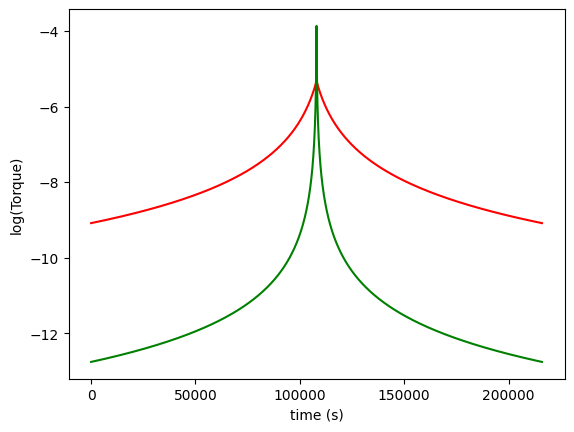

In [749]:
# Time series distances for Neptune and Triton
Rt_neptune = np.linspace(*R_neptune, int(t.size/2))
Rt_neptune = np.concatenate((Rt_neptune, np.flip(Rt_neptune)))

Rt_triton = np.linspace(*R_triton, int(t.size/2))
Rt_triton = np.concatenate((Rt_triton, np.flip(Rt_triton)))

# Function for calculating the gravity gardient disturbance torque
def Tg(R, mu, I):
	Ix, Iy, Iz = I
	coeff = (3 * mu) / (2 * R ** 3)
	Tg = np.abs(Iz - Iy) * coeff
	return Tg

Tg_neptune = np.vectorize(lambda R: Tg(R, mu_neptune, I))(Rt_neptune)
Tg_triton = np.vectorize(lambda R: Tg(R, mu_triton, I))(Rt_triton)


# Plotting the gravitational disturbance torque from Neptune and Triton relative to each other
plt.plot(t, np.log10(Tg_neptune), color="red")
plt.plot(t, np.log10(Tg_triton), color="green")
plt.xlabel("time (s)")
plt.ylabel("log(Torque)")
plt.show()


Max. Neptune B (micro-Teslas): 0.0346420464788552
Planet: Neptune
l_max = 3
Dipole tilt (degrees) = 46.900530
cartopy library not available, using Hammer projection


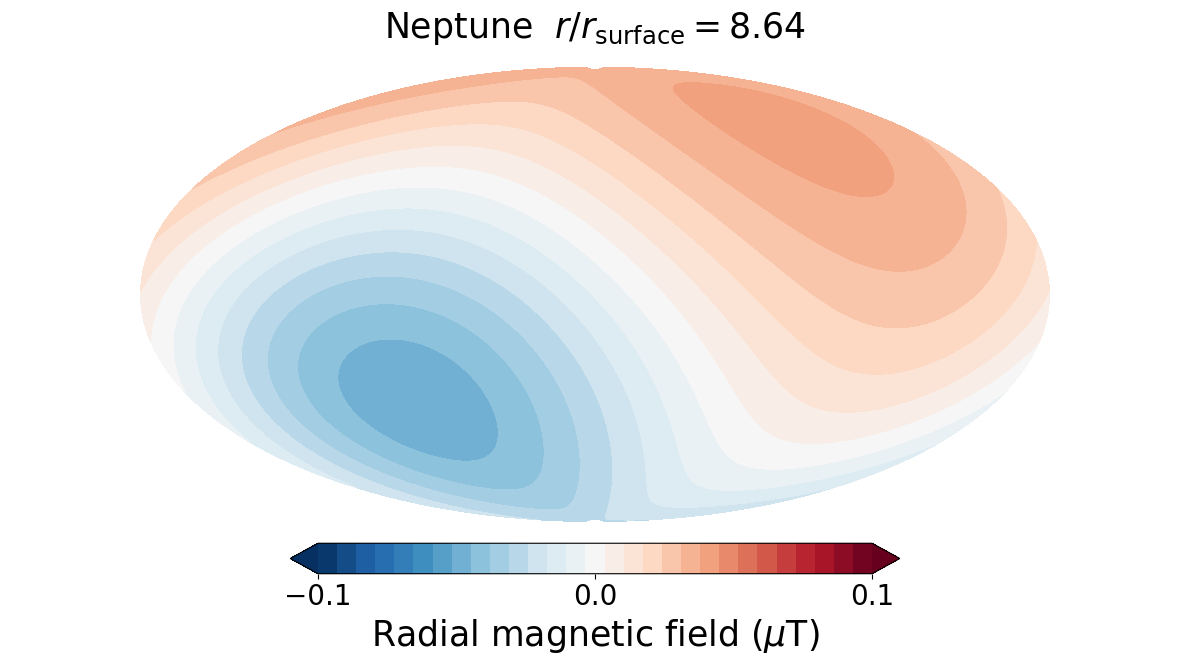

In [750]:
# Magnetic Field Disturbance Torque Calculation
neptune = Planet(name="neptune", datDir="mag_field/data/", info=False)
r = R_neptune[1] / r_neptune 
_, _, Br, _, _ = calcBr(planet=neptune, r=r, info=False)
max_Br_at_min_distance = np.max(Br)
print(f"Max. Neptune B (micro-Teslas): {max_Br_at_min_distance}") # Maximum magnetic field strength at a distance R from the center of mass of neptune
# 8.64 is the lowest value that the simulation can reach but 
# Because it's the highest distance that the mag field engine can plot up to
# In our case the closest distance is r = 9.1228 * R_neptune at which the field is predicted to be even lower than the current calculated value
neptune.plot(r=8.64)

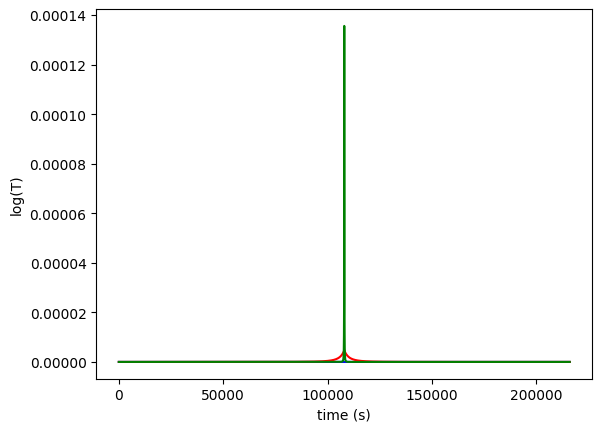

In [751]:
# Final magnetic field calculation:

def calc_B(R):
	r = R / r_neptune 
	_, _, Br, _, _ = calcBr(planet=neptune, r=r, info=False)
	max_Br = np.max(Br)
	return max_Br 

D = 0.4 # in A*m^2 (estimation of the sciencecraft's dipole coming from sample results from this paper https://ieeexplore.ieee.org/document/6978903)

# Returns the magnetic field disturbance torque as a function of distance in Nm
def Tm(R):
	B = calc_B(R)
	# B = 3.4642e-2 # Use max value for similifcation of the calculation
	
	# B in terms of Teslas instead of microteslas
	B_T = B * 1e-6
	return B_T * D

Tm_neptune = np.vectorize(Tm)(Rt_neptune)

# Plotting the gravitational disturbance torque from Neptune and Triton relative to each other
plt.plot(t, Tm_neptune, color="blue")
plt.plot(t, Tg_neptune, color="red")
plt.plot(t, Tg_triton, color="green")
plt.xlabel("time (s)")
plt.ylabel("log(T)")
plt.show()


In [752]:
# Solar Radiation Pressure Calculation

F_srp = Js / c * C_R * As 
def Ts(t):
	# Ts = torque_solar(veh.dim, veh.CG, 0, veh.mat); 
	# Calculate solar radiation pressure torque
	Js =  15 # solar constant

	c = 2.99792458e8 # speed of light
	q_refl = 0.6 # Coeffecient of reflectivity
	# Find surface area of the largest face of orbit
	A_s = boom_length ** 2 * 4
	F = Js * A_s * q_refl / c
	# now calculate torque
	# use CG to find maximum worst case moment arm

	# CG can be assumed to be the same as center of mass for a mass in a uniform gravitational field
	mass_total = 60
	
	CG = [0, 0, 3]
	# If the torque completely hits one side that's directly facing (cannot hit both sides as they will result in 0 torque)
	# 1/2 is coming from the fact that not all of the F_srp force is on the edge of the spectorometer
		# more like a uniform distribution
	# 1/2 coming from the fact that the area being hit cannot be the 
	# total area but instead half so that the torques on the opposite sides do not cancel out
	T_solar = F * 1/2 * max_spectorometer_distance_from_center * 1/2 
	return T_solar

Ts_t = np.vectorize(Ts)(t)

In [753]:
# Caching block for reducing computation time
combined_data = {
	"t": t,
	"Rt_neptune": Rt_neptune,
	"Rt_triton": Rt_neptune,
	"Tm_neptune": Tm_neptune,
	"Tg_neptune": Tg_neptune,
	"Tg_triton": Tg_neptune,
	"Ts_t": Ts_t
}

dataframe = pd.DataFrame(combined_data)
print(dataframe)
dataframe.to_csv("./data/cached_disturbances_time_series.csv", encoding="utf-8")

               t    Rt_neptune     Rt_triton    Tm_neptune    Tg_neptune  \
0            0.0  4.024622e+09  4.024622e+09  2.593690e-12  8.201504e-10   
1            1.0  4.024587e+09  4.024587e+09  2.593758e-12  8.201719e-10   
2            2.0  4.024552e+09  4.024552e+09  2.593826e-12  8.201934e-10   
3            3.0  4.024516e+09  4.024516e+09  2.593894e-12  8.202149e-10   
4            4.0  4.024481e+09  4.024481e+09  2.593962e-12  8.202365e-10   
...          ...           ...           ...           ...           ...   
215995  215995.0  4.024481e+09  4.024481e+09  2.593962e-12  8.202365e-10   
215996  215996.0  4.024516e+09  4.024516e+09  2.593894e-12  8.202149e-10   
215997  215997.0  4.024552e+09  4.024552e+09  2.593826e-12  8.201934e-10   
215998  215998.0  4.024587e+09  4.024587e+09  2.593758e-12  8.201719e-10   
215999  215999.0  4.024622e+09  4.024622e+09  2.593690e-12  8.201504e-10   

           Tg_triton      Ts_t  
0       8.201504e-10  0.000634  
1       8.201719e-10 